OBJECTIVE: Convert cleaned time-series battery data into per-cycle multimodal
dataset where each row = one Battery_ID × one Cycle_No

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)



In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure paths (MODIFY THESE TO YOUR FOLDER STRUCTURE)
BASE_PATH = Path('/content/drive/MyDrive/4 month project/DataSet')
INPUT_PATH = BASE_PATH / 'Processed Files/raw_cleaned'
OUTPUT_PATH = BASE_PATH / 'multimodal_cycles-diksha(notebook2 output)'

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Base Path: {BASE_PATH}")
print(f"✓ Input Path: {INPUT_PATH}")
print(f"✓ Output Path: {OUTPUT_PATH}")
print(f"\n✓ Input files expected:")
print(f"  - {INPUT_PATH / 'ALL_discharge_clean.csv'}")
print(f"  - {INPUT_PATH / 'ALL_charge_clean.csv'}")
print(f"  - {INPUT_PATH / 'ALL_impedance_clean.csv'}")


✓ Base Path: /content/drive/MyDrive/4 month project/DataSet
✓ Input Path: /content/drive/MyDrive/4 month project/DataSet/Processed Files/raw_cleaned
✓ Output Path: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)

✓ Input files expected:
  - /content/drive/MyDrive/4 month project/DataSet/Processed Files/raw_cleaned/ALL_discharge_clean.csv
  - /content/drive/MyDrive/4 month project/DataSet/Processed Files/raw_cleaned/ALL_charge_clean.csv
  - /content/drive/MyDrive/4 month project/DataSet/Processed Files/raw_cleaned/ALL_impedance_clean.csv


load cleaned data

In [ ]:
def load_cleaned_data(input_path):
    """
    Load cleaned discharge, charge, and impedance data.

    Returns:
        tuple: (discharge_df, charge_df, impedance_df)
    """
    print("\n" + "="*80)
    print("LOADING CLEANED DATA")
    print("="*80)

    # Load discharge data (base table)
    discharge_file = input_path / 'ALL_discharge_clean.csv'
    if not discharge_file.exists():
        raise FileNotFoundError(f"Discharge file not found: {discharge_file}")
    discharge_df = pd.read_csv(discharge_file)
    print(f"\n✓ Loaded discharge data: {discharge_df.shape}")
    print(f"  Columns: {list(discharge_df.columns)}")
    print(f"  Batteries: {discharge_df['battery_id'].nunique()}")
    print(f"  Total rows: {len(discharge_df):,}")

    # Load charge data
    charge_file = input_path / 'ALL_charge_clean.csv'
    if not charge_file.exists():
        raise FileNotFoundError(f"Charge file not found: {charge_file}")
    charge_df = pd.read_csv(charge_file)
    print(f"\n✓ Loaded charge data: {charge_df.shape}")
    print(f"  Columns: {list(charge_df.columns)}")
    print(f"  Batteries: {charge_df['battery_id'].nunique()}")
    print(f"  Total rows: {len(charge_df):,}")

    # Load impedance data
    impedance_file = input_path / 'ALL_impedance_clean.csv'
    if not impedance_file.exists():
        raise FileNotFoundError(f"Impedance file not found: {impedance_file}")
    impedance_df = pd.read_csv(impedance_file)
    print(f"\n✓ Loaded impedance data: {impedance_df.shape}")
    print(f"  Columns: {list(impedance_df.columns)}")
    print(f"  Batteries: {impedance_df['battery_id'].nunique()}")
    print(f"  Total rows: {len(impedance_df):,}")

    return discharge_df, charge_df, impedance_df

# Load data
discharge_df, charge_df, impedance_df = load_cleaned_data(INPUT_PATH)


LOADING CLEANED DATA

✓ Loaded discharge data: (770070, 6)
  Columns: ['time_s', 'voltage', 'current', 'temperature', 'cycle_no', 'battery_id']
  Batteries: 34
  Total rows: 770,070

✓ Loaded charge data: (6512876, 6)
  Columns: ['time_s', 'voltage', 'current', 'temperature', 'cycle_no', 'battery_id']
  Batteries: 34
  Total rows: 6,512,876

✓ Loaded impedance data: (1956, 5)
  Columns: ['cycle_no', 'r_real', 'r_imag', 'z_mag', 'battery_id']
  Batteries: 34
  Total rows: 1,956


discharge aggregation

In [ ]:
def aggregate_discharge(discharge_df):
    """
    Aggregate discharge data per (battery_id, cycle_no).

    Features:
    - capacity_Ah: measured capacity
    - discharge_time_sec: total discharge duration
    - voltage_mean, voltage_min, voltage_max
    - temp_mean: average temperature
    - cap_delta: cycle-to-cycle capacity change
    - cap_delta_roll: 3-cycle rolling capacity change
    """
    print("\n" + "="*80)
    print("DISCHARGE AGGREGATION")
    print("="*80)

    # Required columns for discharge
    required_cols = ['battery_id', 'cycle_no', 'voltage', 'temperature']
    missing_cols = [col for col in required_cols if col not in discharge_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required discharge columns: {missing_cols}")

    # Aggregate per cycle
    agg_dict = {
        'voltage': ['mean', 'min', 'max'],
        'temperature': 'mean'
    }

    # Add time_s column if exists
    if 'time_s' in discharge_df.columns:
        agg_dict['time_s'] = lambda x: x.max() - x.min()

    discharge_agg = discharge_df.groupby(['battery_id', 'cycle_no']).agg(agg_dict)
    discharge_agg.columns = ['_'.join(col).strip() if col[1] else col[0]
                              for col in discharge_agg.columns.values]
    discharge_agg = discharge_agg.reset_index()

    # Rename columns
    rename_map = {
        'voltage_mean': 'voltage_mean',
        'voltage_min': 'voltage_min',
        'voltage_max': 'voltage_max',
        'temperature_mean': 'temp_mean'
    }
    if 'time_s_<lambda>' in discharge_agg.columns:
        rename_map['time_s_<lambda>'] = 'discharge_time_sec'

    discharge_agg = discharge_agg.rename(columns=rename_map)

    # Calculate capacity from voltage curve if capacity column exists
    if 'capacity' in discharge_df.columns:
        capacity_agg = discharge_df.groupby(['battery_id', 'cycle_no'])['capacity'].max().reset_index()
        capacity_agg.columns = ['battery_id', 'cycle_no', 'capacity_Ah']
        discharge_agg = discharge_agg.merge(capacity_agg, on=['battery_id', 'cycle_no'], how='left')
    else:
        # Approximate capacity from discharge time (rough estimate)
        if 'discharge_time_sec' in discharge_agg.columns:
            discharge_agg['capacity_Ah'] = discharge_agg['discharge_time_sec'] / 3600 * 1.5

    # Compute capacity deltas per battery
    discharge_agg = discharge_agg.sort_values(['battery_id', 'cycle_no'])
    discharge_agg['cap_delta'] = discharge_agg.groupby('battery_id')['capacity_Ah'].diff()
    discharge_agg['cap_delta_roll'] = discharge_agg.groupby('battery_id')['capacity_Ah'].diff(periods=3)

    print(f"\n✓ Discharge aggregation complete")
    print(f"  Rows: {len(discharge_agg):,}")
    print(f"  Batteries: {discharge_agg['battery_id'].nunique()}")
    print(f"  Cycles per battery: {discharge_agg.groupby('battery_id').size().describe().round(2).to_dict()}")
    print(f"\n  Features: {list(discharge_agg.columns)}")

    return discharge_agg

# Aggregate discharge data
discharge_agg = aggregate_discharge(discharge_df)
print("\nSample discharge aggregation:")
print(discharge_agg.head(10))


DISCHARGE AGGREGATION

✓ Discharge aggregation complete
  Rows: 2,794
  Batteries: 34
  Cycles per battery: {'count': 34.0, 'mean': 82.18, 'std': 56.41, 'min': 25.0, '25%': 40.0, '50%': 69.5, '75%': 112.0, 'max': 197.0}

  Features: ['battery_id', 'cycle_no', 'voltage_mean', 'voltage_min', 'voltage_max', 'temp_mean', 'discharge_time_sec', 'capacity_Ah', 'cap_delta', 'cap_delta_roll']

Sample discharge aggregation:
  battery_id  cycle_no  voltage_mean  voltage_min  voltage_max  temp_mean  \
0      B0005         2      3.532153     2.829771     4.221856       24.0   
1      B0005         4      3.537256     2.828024     4.057062       24.0   
2      B0005         6      3.543669     2.872676     4.056335       24.0   
3      B0005         8      3.543697     2.839647     4.056223       24.0   
4      B0005        10      3.542366     2.814440     4.057491       24.0   
5      B0005        12      3.541342     2.801635     4.059408       24.0   
6      B0005        14      3.541047     2

## Charge Aggregation

In [ ]:
def aggregate_charge(charge_df):
    """
    Aggregate charge data per (battery_id, cycle_no).

    Features:
    - chg_voltage_mean: average charging voltage
    - chg_current_mean: average charging current
    - chg_temp_mean: average charging temperature
    - has_charge: indicator (1 if data exists, 0 otherwise)
    """
    print("\n" + "="*80)
    print("CHARGE AGGREGATION")
    print("="*80)

    # Required columns
    required_cols = ['battery_id', 'cycle_no']
    missing_cols = [col for col in required_cols if col not in charge_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required charge columns: {missing_cols}")

    # Aggregate per cycle
    agg_dict = {}
    if 'voltage' in charge_df.columns:
        agg_dict['voltage'] = 'mean'
    if 'current' in charge_df.columns:
        agg_dict['current'] = 'mean'
    if 'temperature' in charge_df.columns:
        agg_dict['temperature'] = 'mean'

    if not agg_dict:
        print("  ⚠ Warning: No voltage/current/temperature columns found in charge data")
        # Create minimal charge aggregation
        charge_agg = charge_df.groupby(['battery_id', 'cycle_no']).size().reset_index(name='has_charge')
        charge_agg['has_charge'] = 1
        return charge_agg

    charge_agg = charge_df.groupby(['battery_id', 'cycle_no']).agg(agg_dict).reset_index()

    # Rename columns
    rename_map = {
        'voltage': 'chg_voltage_mean',
        'current': 'chg_current_mean',
        'temperature': 'chg_temp_mean'
    }
    charge_agg = charge_agg.rename(columns=rename_map)

    # Add has_charge indicator
    charge_agg['has_charge'] = 1

    print(f"\n✓ Charge aggregation complete")
    print(f"  Rows: {len(charge_agg):,}")
    print(f"  Batteries: {charge_agg['battery_id'].nunique()}")
    print(f"  Features: {list(charge_agg.columns)}")

    return charge_agg

# Aggregate charge data
charge_agg = aggregate_charge(charge_df)
print("\nSample charge aggregation:")
print(charge_agg.head(10))


CHARGE AGGREGATION

✓ Charge aggregation complete
  Rows: 2,815
  Batteries: 34
  Features: ['battery_id', 'cycle_no', 'chg_voltage_mean', 'chg_current_mean', 'chg_temp_mean', 'has_charge']

Sample charge aggregation:
  battery_id  cycle_no  chg_voltage_mean  chg_current_mean  chg_temp_mean  \
0      B0005         1          4.186781          0.642451           24.0   
1      B0005         3          4.058844          0.949038           24.0   
2      B0005         5          4.058155          0.950520           24.0   
3      B0005         7          4.058902          0.952315           24.0   
4      B0005         9          4.058327          0.947730           24.0   
5      B0005        11          4.059782          0.932662           24.0   
6      B0005        13          4.058911          0.932272           24.0   
7      B0005        15          4.053444          0.965321           24.0   
8      B0005        17          4.055633          0.961621           24.0   
9      B000

impedance aggregation

In [ ]:
def aggregate_impedance(impedance_df):
    """
    Aggregate impedance data per (battery_id, cycle_no).

    Features:
    - ir_real_mean: average real impedance
    - ir_imag_mean: average imaginary impedance
    - z_mag_mean: average impedance magnitude
    - ir_real_delta: change in real impedance from previous measurement
    - has_impedance: indicator (1 if measured, 0 after interpolation)
    """
    print("\n" + "="*80)
    print("IMPEDANCE AGGREGATION")
    print("="*80)

    # Required columns
    required_cols = ['battery_id', 'cycle_no']
    missing_cols = [col for col in required_cols if col not in impedance_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required impedance columns: {missing_cols}")

    # Aggregate per cycle
    agg_dict = {}
    if 'real' in impedance_df.columns or 'Re' in impedance_df.columns:
        real_col = 'real' if 'real' in impedance_df.columns else 'Re'
        agg_dict[real_col] = 'mean'
    if 'imag' in impedance_df.columns or 'Im' in impedance_df.columns:
        imag_col = 'imag' if 'imag' in impedance_df.columns else 'Im'
        agg_dict[imag_col] = 'mean'

    if not agg_dict:
        print("  ⚠ Warning: No real/imag impedance columns found")
        # Create minimal impedance aggregation
        impedance_agg = impedance_df.groupby(['battery_id', 'cycle_no']).size().reset_index(name='has_impedance')
        impedance_agg['has_impedance'] = 1
        return impedance_agg

    impedance_agg = impedance_df.groupby(['battery_id', 'cycle_no']).agg(agg_dict).reset_index()

    # Rename columns
    rename_map = {}
    if 'real' in impedance_agg.columns:
        rename_map['real'] = 'ir_real_mean'
    elif 'Re' in impedance_agg.columns:
        rename_map['Re'] = 'ir_real_mean'
    if 'imag' in impedance_agg.columns:
        rename_map['imag'] = 'ir_imag_mean'
    elif 'Im' in impedance_agg.columns:
        rename_map['Im'] = 'ir_imag_mean'

    impedance_agg = impedance_agg.rename(columns=rename_map)

    # Calculate impedance magnitude
    if 'ir_real_mean' in impedance_agg.columns and 'ir_imag_mean' in impedance_agg.columns:
        impedance_agg['z_mag_mean'] = np.sqrt(
            impedance_agg['ir_real_mean']**2 + impedance_agg['ir_imag_mean']**2
        )

    # Calculate delta in real impedance per battery
    impedance_agg = impedance_agg.sort_values(['battery_id', 'cycle_no'])
    if 'ir_real_mean' in impedance_agg.columns:
        impedance_agg['ir_real_delta'] = impedance_agg.groupby('battery_id')['ir_real_mean'].diff()

    # Add has_impedance indicator (1 for measured cycles)
    impedance_agg['has_impedance'] = 1

    print(f"\n✓ Impedance aggregation complete")
    print(f"  Measured rows: {len(impedance_agg):,}")
    print(f"  Batteries: {impedance_agg['battery_id'].nunique()}")
    print(f"  Features: {list(impedance_agg.columns)}")

    return impedance_agg

# Aggregate impedance data
impedance_agg = aggregate_impedance(impedance_df)
print("\nSample impedance aggregation:")
print(impedance_agg.head(10))


IMPEDANCE AGGREGATION
  ⚠ Warning: No real/imag impedance columns found

Sample impedance aggregation:
  battery_id  cycle_no  has_impedance
0      B0005        41              1
1      B0005        43              1
2      B0005        45              1
3      B0005        47              1
4      B0005        49              1
5      B0005        51              1
6      B0005        53              1
7      B0005        55              1
8      B0005        57              1
9      B0005        59              1


merge multimodal data

In [ ]:
def merge_multimodal(discharge_agg, charge_agg, impedance_agg):
    """
    Merge discharge, charge, and impedance data.
    Base table is discharge (all cycles retained).
    """
    print("\n" + "="*80)
    print("MERGING MULTIMODAL DATA")
    print("="*80)

    # Start with discharge as base
    multimodal = discharge_agg.copy()
    print(f"\n✓ Base (discharge): {len(multimodal):,} rows")

    # Left join charge data
    multimodal = multimodal.merge(
        charge_agg,
        on=['battery_id', 'cycle_no'],
        how='left'
    )
    multimodal['has_charge'] = multimodal['has_charge'].fillna(0).astype(int)
    print(f"✓ After charge merge: {len(multimodal):,} rows")
    print(f"  Cycles with charge data: {multimodal['has_charge'].sum():,}")

    # Left join impedance data (sparse)
    multimodal = multimodal.merge(
        impedance_agg,
        on=['battery_id', 'cycle_no'],
        how='left'
    )
    multimodal['has_impedance'] = multimodal['has_impedance'].fillna(0).astype(int)
    measured_impedance = multimodal['has_impedance'].sum()
    print(f"✓ After impedance merge: {len(multimodal):,} rows")
    print(f"  Cycles with measured impedance: {measured_impedance:,}")
    print(f"  Impedance sparsity: {measured_impedance / len(multimodal) * 100:.2f}%")

    return multimodal

# Merge all modalities
multimodal = merge_multimodal(discharge_agg, charge_agg, impedance_agg)
print("\nSample merged data:")
print(multimodal.head(10))


MERGING MULTIMODAL DATA

✓ Base (discharge): 2,794 rows
✓ After charge merge: 2,794 rows
  Cycles with charge data: 0
✓ After impedance merge: 2,794 rows
  Cycles with measured impedance: 0
  Impedance sparsity: 0.00%

Sample merged data:
  battery_id  cycle_no  voltage_mean  voltage_min  voltage_max  temp_mean  \
0      B0005         2      3.532153     2.829771     4.221856       24.0   
1      B0005         4      3.537256     2.828024     4.057062       24.0   
2      B0005         6      3.543669     2.872676     4.056335       24.0   
3      B0005         8      3.543697     2.839647     4.056223       24.0   
4      B0005        10      3.542366     2.814440     4.057491       24.0   
5      B0005        12      3.541342     2.801635     4.059408       24.0   
6      B0005        14      3.541047     2.784671     4.060463       24.0   
7      B0005        16      3.554073     2.887464     4.062566       24.0   
8      B0005        18      3.552983     2.852749     4.061330     

impedance interpolation

In [ ]:
def interpolate_impedance(multimodal):
    """
    Linearly interpolate sparse impedance data per battery.

    Rules:
    - Only interpolate between first and last measured cycle
    - Do NOT extrapolate beyond measured range
    - Keep has_impedance flag unchanged (shows original measurements)
    """
    print("\n" + "="*80)
    print("IMPEDANCE INTERPOLATION")
    print("="*80)

    impedance_cols = ['ir_real_mean', 'ir_imag_mean', 'z_mag_mean', 'ir_real_delta']
    available_cols = [col for col in impedance_cols if col in multimodal.columns]

    if not available_cols:
        print("  ⚠ No impedance columns to interpolate")
        return multimodal

    print(f"\n  Interpolating columns: {available_cols}")

    # Before interpolation stats
    before_stats = {}
    for col in available_cols:
        before_stats[col] = multimodal[col].notna().sum()
        print(f"  Before - {col}: {before_stats[col]:,} non-null values")

    # Interpolate per battery
    multimodal = multimodal.sort_values(['battery_id', 'cycle_no'])

    interpolated_dfs = []
    for battery_id, battery_df in multimodal.groupby('battery_id'):
        battery_df = battery_df.copy()

        # Find first and last measured impedance cycle
        measured_mask = battery_df['has_impedance'] == 1
        if measured_mask.sum() == 0:
            interpolated_dfs.append(battery_df)
            continue

        first_measured = battery_df[measured_mask]['cycle_no'].min()
        last_measured = battery_df[measured_mask]['cycle_no'].max()

        # Only interpolate within measured range
        interp_mask = (battery_df['cycle_no'] >= first_measured) & \
                      (battery_df['cycle_no'] <= last_measured)

        for col in available_cols:
            if col in battery_df.columns:
                # Interpolate only within measured range
                battery_df.loc[interp_mask, col] = battery_df.loc[interp_mask, col].interpolate(
                    method='linear',
                    limit_direction='both',
                    limit_area='inside'
                )

        interpolated_dfs.append(battery_df)

    multimodal = pd.concat(interpolated_dfs, ignore_index=True)

    # After interpolation stats
    print("\n  After interpolation:")
    for col in available_cols:
        after_count = multimodal[col].notna().sum()
        added = after_count - before_stats[col]
        print(f"  {col}: {after_count:,} non-null (+{added:,} interpolated)")

    print(f"\n✓ Impedance interpolation complete")
    print(f"  Original measurements preserved in 'has_impedance' column")

    return multimodal

# Interpolate impedance
multimodal = interpolate_impedance(multimodal)


IMPEDANCE INTERPOLATION
  ⚠ No impedance columns to interpolate


data validation

In [ ]:
def validate_multimodal(multimodal):
    """
    Comprehensive validation of multimodal dataset.
    """
    print("\n" + "="*80)
    print("DATA VALIDATION")
    print("="*80)

    # Basic stats
    print(f"\n📊 DATASET SUMMARY:")
    print(f"  Total rows: {len(multimodal):,}")
    print(f"  Total batteries: {multimodal['battery_id'].nunique()}")
    print(f"  Columns: {len(multimodal.columns)}")

    # Per-battery stats
    cycles_per_battery = multimodal.groupby('battery_id').size()
    print(f"\n📊 CYCLES PER BATTERY:")
    print(f"  Mean: {cycles_per_battery.mean():.1f}")
    print(f"  Median: {cycles_per_battery.median():.1f}")
    print(f"  Min: {cycles_per_battery.min()}")
    print(f"  Max: {cycles_per_battery.max()}")

    # Impedance stats
    measured_impedance = (multimodal['has_impedance'] == 1).sum()
    print(f"\n📊 IMPEDANCE COVERAGE:")
    print(f"  Measured cycles: {measured_impedance:,}")
    print(f"  Coverage: {measured_impedance / len(multimodal) * 100:.2f}%")

    # Check for duplicates
    print(f"\n✓ DUPLICATE CHECK:")
    duplicates = multimodal.duplicated(subset=['battery_id', 'cycle_no']).sum()
    print(f"  Duplicates: {duplicates}")
    assert duplicates == 0, "❌ CRITICAL: Duplicate (battery_id, cycle_no) pairs found!"
    print("  ✓ No duplicates found")

    # Check cycle monotonicity
    print(f"\n✓ MONOTONICITY CHECK:")
    non_monotonic = 0
    for battery_id, battery_df in multimodal.groupby('battery_id'):
        if not battery_df['cycle_no'].is_monotonic_increasing:
            non_monotonic += 1
            print(f"  ⚠ Battery {battery_id}: non-monotonic cycles")

    if non_monotonic == 0:
        print("  ✓ All batteries have monotonic cycle numbers")
    else:
        print(f"  ⚠ {non_monotonic} batteries have non-monotonic cycles")

    # Missing data summary
    print(f"\n📊 MISSING DATA SUMMARY:")
    missing_pct = (multimodal.isnull().sum() / len(multimodal) * 100).round(2)
    missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)
    if len(missing_cols) > 0:
        for col, pct in missing_cols.items():
            print(f"  {col}: {pct}%")
    else:
        print("  ✓ No missing data")

    # Column summary
    print(f"\n📊 FEATURE SUMMARY:")
    print(f"  Total features: {len(multimodal.columns)}")
    print(f"  Feature list:")
    for col in multimodal.columns:
        dtype = multimodal[col].dtype
        print(f"    - {col} ({dtype})")

    return True

# Validate dataset
validate_multimodal(multimodal)


DATA VALIDATION

📊 DATASET SUMMARY:
  Total rows: 2,794
  Total batteries: 34
  Columns: 15

📊 CYCLES PER BATTERY:
  Mean: 82.2
  Median: 69.5
  Min: 25
  Max: 197

📊 IMPEDANCE COVERAGE:
  Measured cycles: 0
  Coverage: 0.00%

✓ DUPLICATE CHECK:
  Duplicates: 0
  ✓ No duplicates found

✓ MONOTONICITY CHECK:
  ✓ All batteries have monotonic cycle numbers

📊 MISSING DATA SUMMARY:
  chg_voltage_mean: 100.0%
  chg_temp_mean: 100.0%
  chg_current_mean: 100.0%
  cap_delta_roll: 3.65%
  cap_delta: 1.22%

📊 FEATURE SUMMARY:
  Total features: 15
  Feature list:
    - battery_id (object)
    - cycle_no (int64)
    - voltage_mean (float64)
    - voltage_min (float64)
    - voltage_max (float64)
    - temp_mean (float64)
    - discharge_time_sec (float64)
    - capacity_Ah (float64)
    - cap_delta (float64)
    - cap_delta_roll (float64)
    - chg_voltage_mean (float64)
    - chg_current_mean (float64)
    - chg_temp_mean (float64)
    - has_charge (int64)
    - has_impedance (int64)


True

In [ ]:
def save_multimodal_data(multimodal, output_path):
    """
    Save multimodal dataset:
    - One file per battery (for validation)
    - One combined file (for downstream pipeline)
    """
    print("\n" + "="*80)
    print("SAVING OUTPUTS")
    print("="*80)

    # Save individual battery files
    battery_output_path = output_path / 'multimodal_per_battery'
    battery_output_path.mkdir(exist_ok=True)

    for battery_id, battery_df in multimodal.groupby('battery_id'):
        battery_file = battery_output_path / f'{battery_id}_multimodal_cycles.csv'
        battery_df.to_csv(battery_file, index=False)
        print(f"  ✓ Saved {battery_id}: {len(battery_df)} cycles")

    print(f"\n✓ Individual battery files saved to: {battery_output_path}")

    # Save combined file
    combined_file = output_path / 'ALL_multimodal_cycles.csv'
    multimodal.to_csv(combined_file, index=False)
    print(f"\n✓ Combined file saved: {combined_file}")
    print(f"  Total rows: {len(multimodal):,}")
    print(f"  File size: {combined_file.stat().st_size / 1024 / 1024:.2f} MB")

    return combined_file

# Save outputs
combined_file = save_multimodal_data(multimodal, OUTPUT_PATH)


SAVING OUTPUTS
  ✓ Saved B0005: 168 cycles
  ✓ Saved B0006: 168 cycles
  ✓ Saved B0007: 168 cycles
  ✓ Saved B0018: 132 cycles
  ✓ Saved B0025: 28 cycles
  ✓ Saved B0026: 28 cycles
  ✓ Saved B0027: 28 cycles
  ✓ Saved B0028: 28 cycles
  ✓ Saved B0029: 40 cycles
  ✓ Saved B0030: 40 cycles
  ✓ Saved B0031: 40 cycles
  ✓ Saved B0032: 40 cycles
  ✓ Saved B0033: 197 cycles
  ✓ Saved B0034: 197 cycles
  ✓ Saved B0036: 197 cycles
  ✓ Saved B0038: 47 cycles
  ✓ Saved B0039: 47 cycles
  ✓ Saved B0040: 47 cycles
  ✓ Saved B0041: 67 cycles
  ✓ Saved B0042: 112 cycles
  ✓ Saved B0043: 112 cycles
  ✓ Saved B0044: 112 cycles
  ✓ Saved B0045: 72 cycles
  ✓ Saved B0046: 72 cycles
  ✓ Saved B0047: 72 cycles
  ✓ Saved B0048: 72 cycles
  ✓ Saved B0049: 25 cycles
  ✓ Saved B0050: 25 cycles
  ✓ Saved B0051: 25 cycles
  ✓ Saved B0052: 25 cycles
  ✓ Saved B0053: 56 cycles
  ✓ Saved B0054: 103 cycles
  ✓ Saved B0055: 102 cycles
  ✓ Saved B0056: 102 cycles

✓ Individual battery files saved to: /content/drive/

summary


VISUALIZATION

✓ Summary plots saved: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)/multimodal_summary.png


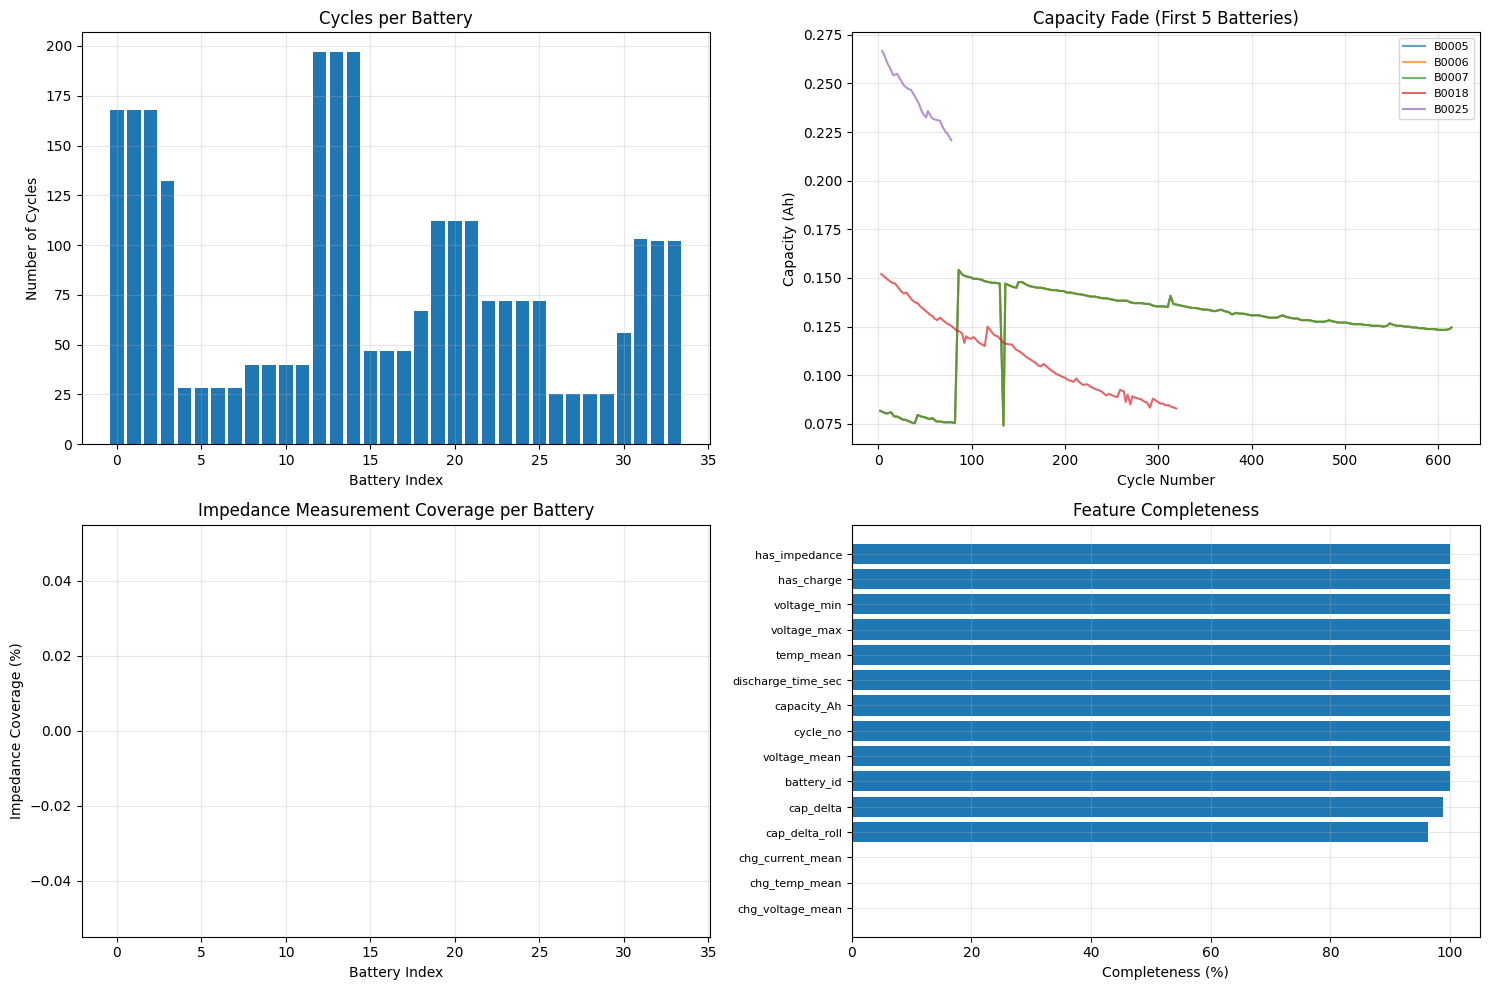

In [ ]:
def plot_summary_statistics(multimodal, output_path):
    """
    Visualize key statistics of the multimodal dataset.
    """
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Cycles per battery
    cycles_per_battery = multimodal.groupby('battery_id').size()
    axes[0, 0].bar(range(len(cycles_per_battery)), cycles_per_battery.values)
    axes[0, 0].set_xlabel('Battery Index')
    axes[0, 0].set_ylabel('Number of Cycles')
    axes[0, 0].set_title('Cycles per Battery')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Capacity evolution
    for battery_id in multimodal['battery_id'].unique()[:5]:  # Show first 5 batteries
        battery_df = multimodal[multimodal['battery_id'] == battery_id]
        if 'capacity_Ah' in battery_df.columns:
            axes[0, 1].plot(battery_df['cycle_no'], battery_df['capacity_Ah'],
                           label=battery_id, alpha=0.7)
    axes[0, 1].set_xlabel('Cycle Number')
    axes[0, 1].set_ylabel('Capacity (Ah)')
    axes[0, 1].set_title('Capacity Fade (First 5 Batteries)')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Impedance coverage
    impedance_coverage = multimodal.groupby('battery_id')['has_impedance'].mean() * 100
    axes[1, 0].bar(range(len(impedance_coverage)), impedance_coverage.values)
    axes[1, 0].set_xlabel('Battery Index')
    axes[1, 0].set_ylabel('Impedance Coverage (%)')
    axes[1, 0].set_title('Impedance Measurement Coverage per Battery')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Feature completeness
    completeness = (1 - multimodal.isnull().sum() / len(multimodal)) * 100
    completeness = completeness.sort_values()
    axes[1, 1].barh(range(len(completeness)), completeness.values)
    axes[1, 1].set_yticks(range(len(completeness)))
    axes[1, 1].set_yticklabels(completeness.index, fontsize=8)
    axes[1, 1].set_xlabel('Completeness (%)')
    axes[1, 1].set_title('Feature Completeness')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_path / 'multimodal_summary.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Summary plots saved: {output_path / 'multimodal_summary.png'}")
    plt.show()

# Generate visualizations
plot_summary_statistics(multimodal, OUTPUT_PATH)

In [ ]:
print("\n" + "="*80)
print("NOTEBOOK-2 COMPLETE ✓")
print("="*80)
print(f"\n📁 OUTPUT FILES:")
print(f"  - Combined: {OUTPUT_PATH / 'ALL_multimodal_cycles.csv'}")
print(f"  - Per-battery: {OUTPUT_PATH / 'multimodal_per_battery/'}")
print(f"  - Visualization: {OUTPUT_PATH / 'multimodal_summary.png'}")

print(f"\n📊 FINAL DATASET:")
print(f"  Total rows: {len(multimodal):,}")
print(f"  Total batteries: {multimodal['battery_id'].nunique()}")
print(f"  Total features: {len(multimodal.columns)}")
print(f"  Impedance coverage: {(multimodal['has_impedance'] == 1).sum() / len(multimodal) * 100:.2f}%")


NOTEBOOK-2 COMPLETE ✓

📁 OUTPUT FILES:
  - Combined: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)/ALL_multimodal_cycles.csv
  - Per-battery: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)/multimodal_per_battery
  - Visualization: /content/drive/MyDrive/4 month project/DataSet/multimodal_cycles-diksha(notebook2 output)/multimodal_summary.png

📊 FINAL DATASET:
  Total rows: 2,794
  Total batteries: 34
  Total features: 15
  Impedance coverage: 0.00%
